In [1]:
import os
import numpy as np
import pandas as pd
import re
from gensim.models import Word2Vec

In [2]:
from sklearn import model_selection, preprocessing
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers, utils

C:\Users\Sanghu\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load Training data

In [3]:
currentdir = os.getcwd()
input_data = pd.read_csv(os.path.join(currentdir, r'ndsc-beginner\train.csv'))
input_data.head(5)

,itemid,title,Category,image_path
0,307504,nyx sex bomb pallete natural palette,0,beauty_image/6b2e9cbb279ac95703348368aa65da09.jpg
1,461203,etude house precious mineral any cushion pearl...,1,beauty_image/20450222d857c9571ba8fa23bdedc8c9.jpg
2,3592295,milani rose powder blush,2,beauty_image/6a5962bed605a3dd6604ca3a4278a4f9.jpg
3,4460167,etude house baby sweet sugar powder,3,beauty_image/56987ae186e8a8e71fcc5a261ca485da.jpg
4,5853995,bedak revlon color stay aqua mineral make up,3,beauty_image/9c6968066ebab57588c2f757a240d8b9.jpg


In [4]:
# Load training data
train_data = input_data[['title', 'Category']]
print(train_data.shape)
print(train_data.head())

data = train_data.sample(frac=0.5)
print(data.shape)
# data['Category'].value_counts()

(666615, 2)
                                               title  Category
0               nyx sex bomb pallete natural palette         0
1  etude house precious mineral any cushion pearl...         1
2                           milani rose powder blush         2
3                etude house baby sweet sugar powder         3
4       bedak revlon color stay aqua mineral make up         3
(333308, 2)


In [5]:
# Load and prepare test data
test = pd.read_csv(os.path.join(currentdir, r'ndsc-beginner\test.csv'))
print(test.shape)
print(test.head(5))

(172402, 3)
       itemid                                              title  \
0   370855998               flormar 7 white cream bb spf 30 40ml   
1   637234604  maybelline clear smooth all in one bb cream sp...   
2   690282890  murah innisfree eco natural green tea bb cream...   
3   930913462  loreal white perfect day cream spf 17 pa white...   
4  1039280071  hada labo cc cream ultimate anti aging spf 35 ...   

                                          image_path  
0  beauty_image/1588591395c5a254bab84042005f2a9f.jpg  
1  beauty_image/920985ed9587ea20f58686ea74e20f93.jpg  
2  beauty_image/90b40e5710f54352b243fcfb0f5d1d7f.jpg  
3  beauty_image/289c668ef3d70e1d929d602d52d5d78a.jpg  
4  beauty_image/d5b3e652c5822d2306f4560488ec30c6.jpg  


# Custom Word embeddings

In [6]:
text_df = input_data['title'].append(test['title'], ignore_index=True)
print(text_df.shape)
text_df.head()

(839017,)


0                 nyx sex bomb pallete natural palette
1    etude house precious mineral any cushion pearl...
2                             milani rose powder blush
3                  etude house baby sweet sugar powder
4         bedak revlon color stay aqua mineral make up
Name: title, dtype: object

In [7]:
# Data cleaning on title to prepare custom word embedding 
text_clean = []
for title in text_df:
    t = re.sub('[^a-zA-Z ]', '', title) # removes numbers from text: etu67de 64gb' = 'etude gb'
    t1 = re.sub(r'\b\w{1,1}\b', '', t) # removes words with length<1    
    text_clean.append(t1.split())

In [243]:
# tt = []
# result = ['et45u5de 23 ho23use22 2.5 5.777 g6489b 2m a2m 3pre5567cious7 mi6neral any cushion pearl', 
#           'nyx sex bomb pallete natural palette',
#           'etude house baby sweet sugar powder']
# for i in result:
#     t = re.sub('[^a-zA-Z ]', '', i) # removes numbers from text: etu67de 64gb' = 'etude gb'
#     t1 = re.sub(r'\b\w{1,1}\b', '', t) # removes words with length<1
#     tt.append(t1.split())
# print(tt)

In [8]:
# Gensim custom word embedding model
embedding_dim = 100 # size of word_vector

word2vec_model = Word2Vec(text_clean, min_count=2, sg=1, size=embedding_dim ,workers=4)

word2vec_model.wv.save_word2vec_format('custom_embed_100d.txt')

print("Found %s unique vectors" %len(word2vec_model.wv.vocab.keys()))

# word2vec_model.wv.most_similar('cosmetics')

Found 29431 unique vectors


# Data Preparation - Training data

In [24]:
# Converting text data and labels to list of lists
texts =[]
labels = []

for i, line in train_data.iterrows():
    texts.append(line['title'])
    labels.append(line['Category'])

print("Found %s texts" % len(texts))

print(set(labels))

Found 666615 texts
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57}


In [25]:
# create a tokenizer 
tokenize = text.Tokenizer()
# fit tokenizer on texts
tokenize.fit_on_texts(texts)
# creates a dict of unique words and their ID
word_index = tokenize.word_index

print("Found %s unique tokens" % len(word_index))

Found 80091 unique tokens


In [26]:
# integer encode documents using word_index
encoded_texts = tokenize.texts_to_sequences(texts)

#to find max_sequence_length
def find_max_list(listoflist):
    list_len = [len(i) for i in listoflist]
    return max(list_len)

max_sequence_length = find_max_list(encoded_texts)+1

# pad the text vectors to make them of equal length
padded_texts = sequence.pad_sequences(encoded_texts ,padding='post',maxlen=max_sequence_length)

In [27]:
print("Texts:",texts[0:5])
print("\nEncoded Texts:",encoded_texts[0:5])
print("\nPadded Texts:",padded_texts[0:5])

Texts: ['nyx sex bomb pallete natural palette', 'etude house precious mineral any cushion pearl aura puff', 'milani rose powder blush', 'etude house baby sweet sugar powder', 'bedak revlon color stay aqua mineral make up']

Encoded Texts: [[159, 9054, 5830, 1089, 71, 321], [82, 102, 326, 132, 958, 23, 1292, 1389, 690], [527, 257, 6, 133], [82, 102, 378, 659, 1612, 6], [38, 331, 124, 461, 663, 132, 104, 106]]

Padded Texts: [[ 159 9054 5830 1089   71  321    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [  82  102  326  132  958   23 1292 1389  690    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [ 527  257    6  133    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [  82  102  378  659 1612    6    0    0    0    0    0 

In [28]:
num_classes = np.max(labels)+1
labels= utils.to_categorical(labels, num_classes)

print("Shape of text data :", padded_texts.shape)
print("Shape of labels :", labels.shape)

Shape of text data : (666615, 33)
Shape of labels : (666615, 58)


# Data Preparation - Test data

In [37]:
# Converting text data to list of lists
test_texts =[]

for i, line in test.iterrows():
    test_texts.append(line['title'])

print("Found %s texts to test" % len(test_texts))

Found 172402 texts to test


In [38]:
# integer encode documents using word_index
test_encoded_texts = tokenize.texts_to_sequences(test_texts)

#to find max_sequence_length
def find_max_list(listoflist):
    list_len = [len(i) for i in listoflist]
    return max(list_len)

test_max_sequence_length = find_max_list(test_encoded_texts)+1

# pad the text vectors to make them of equal length
x_test = sequence.pad_sequences(test_encoded_texts ,padding='post',maxlen=max_sequence_length)

In [39]:
# Split data and labels into training and validation
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(padded_texts, labels, random_state =42)

print("Shape of x_train", x_train.shape)
print("Shape of x_valid", x_valid.shape)
print("Shape of y_train", y_train.shape)
print("Shape of y_valid", y_valid.shape)
print("Shape of x_test", x_test.shape)

Shape of x_train (499961, 33)
Shape of x_valid (166654, 33)
Shape of y_train (499961, 58)
Shape of y_valid (166654, 58)
Shape of x_test (172402, 33)



# Preparing for embedding layer(custom)

In [32]:
embedding_dim = 100
vocabulary_size = len(word_index)+1

In [33]:
# load the custom pre-trained word-embedding vectors 
embeddings_index = {}
f = open('custom_embed_100d.txt', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors' % len(embeddings_index))

Found 29432 word vectors


In [34]:
# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Conv1D model

In [40]:
# This model gave 73.275% for test data when run with 100% train data. With 50%, acc stands at 72.451% for test data
sequence_input = layers.Input(shape=(max_sequence_length,), dtype='int32')

embedding_layer = layers.Embedding(vocabulary_size,
                                    embedding_dim,
                                    weights=[embedding_matrix],
                                    input_length=max_sequence_length,
                                    trainable=True)

embedded_sequences = embedding_layer(sequence_input)
x = layers.Convolution1D(256, 2, activation='relu')(embedded_sequences)
x = layers.Convolution1D(256, 2, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Convolution1D(128, 2, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Convolution1D(128, 2, activation='relu')(x)
x = layers.MaxPooling1D(2)(x) 
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
preds = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(sequence_input, preds)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 33)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 33, 100)           8009200   
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 32, 256)           51456     
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 31, 256)           131328    
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 15, 256)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 14, 128)           65664     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 7, 128)            0         
__________

In [41]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', #rmsprop
              metrics=['acc'])

history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
          epochs=7, batch_size=128, verbose=1 ) 

Train on 499961 samples, validate on 166654 samples
Epoch 1/7
499961/499961 [==============================] - 607s 1ms/step - loss: 1.1910 - acc: 0.6517 - val_loss: 0.9802 - val_acc: 0.6983
Epoch 2/7
499961/499961 [==============================] - 616s 1ms/step - loss: 0.9866 - acc: 0.7029 - val_loss: 0.9387 - val_acc: 0.7111
Epoch 3/7
499961/499961 [==============================] - 615s 1ms/step - loss: 0.9253 - acc: 0.7189 - val_loss: 0.9172 - val_acc: 0.7171
Epoch 4/7
499961/499961 [==============================] - 636s 1ms/step - loss: 0.8764 - acc: 0.7322 - val_loss: 0.9131 - val_acc: 0.7189
Epoch 5/7
499961/499961 [==============================] - 657s 1ms/step - loss: 0.8387 - acc: 0.7430 - val_loss: 0.9103 - val_acc: 0.7212
Epoch 6/7
499961/499961 [==============================] - 670s 1ms/step - loss: 0.8092 - acc: 0.7515 - val_loss: 0.9108 - val_acc: 0.7223
Epoch 7/7
499961/499961 [==============================] - 655s 1ms/step - loss: 0.7848 - acc: 0.7580 - val_loss: 

# Plot Accuracy vs Loss

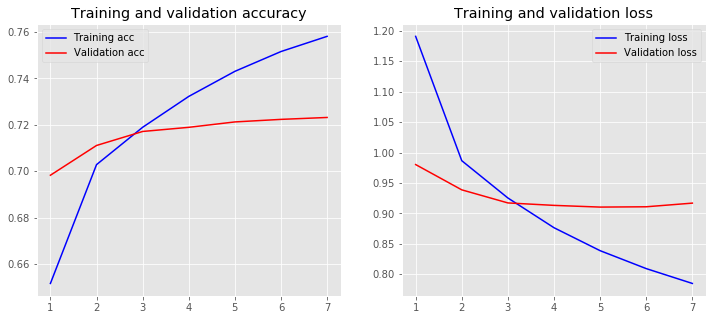

In [42]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_history(history)

In [43]:
test_label = model.predict(x_test)

In [44]:
y_test =[]
for i in test_label:
    max_id = np.where(i== np.amax(i))
    y_test.append(max_id[0][0])

print(y_test)

[5, 5, 5, 5, 5, 3, 4, 5, 5, 5, 5, 2, 3, 4, 5, 5, 3, 9, 5, 3, 3, 3, 5, 5, 3, 5, 3, 5, 4, 3, 5, 5, 3, 3, 5, 3, 3, 3, 3, 3, 3, 7, 5, 3, 5, 2, 3, 7, 5, 5, 3, 3, 5, 5, 4, 3, 3, 3, 1, 3, 4, 5, 5, 3, 5, 3, 5, 3, 4, 5, 5, 5, 5, 3, 3, 3, 5, 3, 3, 5, 5, 5, 1, 5, 3, 3, 3, 1, 5, 3, 5, 5, 5, 3, 5, 1, 3, 3, 5, 5, 5, 5, 3, 5, 1, 3, 3, 5, 5, 5, 5, 3, 5, 3, 3, 3, 5, 1, 3, 3, 5, 3, 3, 5, 5, 3, 3, 7, 5, 3, 5, 3, 5, 1, 1, 5, 4, 5, 5, 3, 3, 7, 5, 4, 0, 3, 3, 5, 3, 7, 3, 5, 5, 7, 3, 5, 5, 3, 7, 5, 3, 3, 1, 5, 5, 3, 3, 1, 3, 5, 5, 5, 5, 5, 3, 5, 1, 3, 3, 3, 5, 5, 2, 3, 3, 5, 5, 7, 3, 5, 5, 5, 3, 3, 5, 5, 4, 5, 5, 5, 5, 9, 1, 3, 3, 5, 5, 3, 3, 3, 5, 5, 5, 3, 5, 5, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 5, 1, 7, 3, 5, 5, 5, 5, 3, 5, 5, 4, 5, 3, 3, 1, 3, 5, 3, 2, 5, 1, 5, 5, 5, 5, 5, 9, 3, 4, 3, 5, 5, 3, 3, 5, 3, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 1, 5, 3, 5, 4, 1, 5, 3, 5, 5, 5, 1, 3, 5, 5, 5, 3, 3, 3, 3, 3, 6, 5, 7, 3, 5, 5, 3, 5, 5, 5, 5, 5, 3, 4, 5, 5, 3, 1, 5, 5, 3, 5, 5, 7, 5, 3, 3, 5, 1, 5, 3, 3, 5, 5, 5, 1, 3, 3, 

In [45]:
test['Category'] = y_test
submission_df = test[['itemid', 'Category']]
submission_df.to_csv('submission.csv', index=False) 

# LSTM model with CNN

In [46]:
# I ran this model for 50% training data and got 72.492% for test data. And currently running with 100% data
model2 = models.Sequential()
model2.add(layers.Embedding(vocabulary_size,embedding_dim,weights=[embedding_matrix],
                             input_length=max_sequence_length,trainable=True))
model2.add(layers.Convolution1D(256, 2, activation='relu'))
model2.add(layers.Convolution1D(256, 2, activation='relu'))
model2.add(layers.MaxPooling1D(2))
model2.add(layers.Dropout(0.2))
model2.add(layers.LSTM(100, activation = 'tanh', recurrent_activation='hard_sigmoid', dropout=0.2))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(num_classes, activation='softmax'))
print(model2.summary())

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 33, 100)           8009200   
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 32, 256)           51456     
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 31, 256)           131328    
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 15, 256)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               142800    
_________________________________________________________________
dropout_17 (Dropout)         (None, 100)               0         
__________

In [ ]:
history2 = model2.fit(x_train, y_train, validation_data=(x_valid, y_valid),
          epochs=10, batch_size=128, verbose=1 ) 
#im still running this with full data

Train on 499961 samples, validate on 166654 samples
Epoch 1/10
424832/499961 [========================>.....] - ETA: 1:36 - loss: 1.2128 - acc: 0.6399

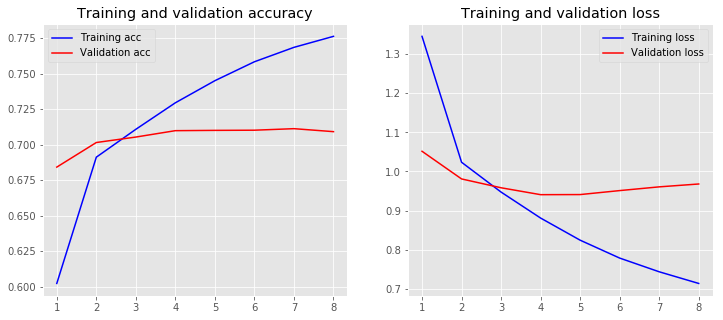

In [315]:
plot_history(history2)

In [316]:
test_label2 = model2.predict(x_test)

In [317]:
y_test2 =[]
for i in test_label2:
    max_id2 = np.where(i== np.amax(i))
    y_test2.append(max_id2[0][0])

print(y_test2)

[5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 2, 3, 4, 1, 5, 3, 9, 5, 3, 3, 3, 5, 5, 3, 5, 3, 5, 4, 3, 5, 5, 3, 3, 5, 3, 3, 3, 3, 3, 3, 7, 5, 3, 5, 2, 3, 7, 5, 5, 3, 3, 5, 5, 4, 3, 1, 3, 1, 3, 4, 5, 5, 3, 5, 3, 5, 3, 4, 5, 5, 5, 5, 3, 3, 3, 5, 3, 3, 5, 5, 5, 1, 5, 3, 3, 3, 1, 5, 3, 5, 5, 5, 3, 5, 1, 3, 3, 5, 5, 5, 5, 3, 5, 1, 3, 5, 5, 5, 5, 5, 3, 5, 1, 3, 3, 5, 1, 3, 3, 5, 3, 5, 5, 5, 1, 3, 7, 5, 5, 5, 3, 3, 1, 4, 5, 5, 5, 5, 3, 3, 7, 5, 4, 3, 3, 3, 5, 3, 7, 3, 5, 5, 5, 3, 1, 5, 3, 7, 5, 3, 3, 1, 5, 5, 1, 3, 1, 3, 5, 5, 5, 5, 5, 3, 5, 1, 3, 3, 3, 5, 5, 2, 3, 3, 5, 5, 3, 3, 5, 5, 4, 3, 3, 5, 5, 9, 5, 5, 5, 3, 5, 1, 3, 5, 1, 4, 3, 3, 3, 5, 5, 5, 3, 5, 5, 3, 3, 3, 5, 3, 3, 3, 3, 3, 5, 3, 5, 1, 7, 3, 5, 5, 5, 5, 3, 5, 5, 4, 5, 3, 3, 1, 4, 5, 3, 1, 5, 1, 3, 5, 5, 5, 5, 9, 3, 4, 3, 5, 5, 3, 3, 5, 3, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 1, 5, 3, 5, 5, 1, 5, 3, 5, 5, 5, 1, 3, 5, 5, 5, 3, 3, 3, 3, 3, 11, 5, 7, 3, 5, 5, 3, 5, 5, 1, 3, 5, 3, 4, 5, 5, 3, 1, 5, 5, 3, 5, 5, 7, 5, 3, 3, 3, 1, 5, 3, 3, 5, 5, 5, 1, 3, 3,

In [318]:
test['Category'] = y_test2
submission_df = test[['itemid', 'Category']]
submission_df.to_csv('submission.csv', index=False)